In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import os

%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape

# stochastic gradient descent
from tensorflow.keras.optimizers import SGD

import plaidml.keras
plaidml.keras.install_backend()
from keras import backend as K

In [2]:
# get data

from tensorflow.keras.datasets import mnist

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

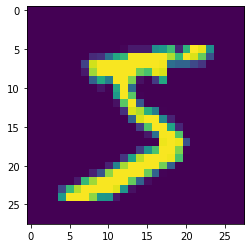

In [6]:
plt.imshow(X_train[0])

In [7]:
# scale the data

X_train = X_train/255
X_test = X_test/255

In [10]:
# have 28 x 28 pixel = 784 -> scale down in half going to 25 which is 3.2% 

encoder = Sequential()
encoder.add(Flatten(input_shape=[28,28]))
encoder.add(Dense(400, activation='relu'))
encoder.add(Dense(200, activation='relu'))
encoder.add(Dense(100, activation='relu'))
encoder.add(Dense(50, activation='relu'))
encoder.add(Dense(25, activation='relu'))

In [11]:
decoder = Sequential()

decoder = Sequential()
decoder.add(Dense(50, input_shape = [25], activation='relu'))
decoder.add(Dense(100, activation='relu'))
decoder.add(Dense(200, activation='relu'))
decoder.add(Dense(400, activation='relu'))
# checking does input image match output image - binary issue
decoder.add(Dense(784, activation='sigmoid'))
decoder.add(Reshape([28,28]))


In [12]:
autoencoder = Sequential([encoder, decoder])

In [14]:
autoencoder.compile(loss = 'binary_crossentropy',
                   optimizer = SGD(lr=1.5),
                   metrics=['accuracy'])

In [15]:
autoencoder.fit(X_train, X_train, epochs = 5,
               validation_data=[X_test, X_test])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 14s 241us/sample - loss: 0.2494 - accuracy: 0.7907 - val_loss: 0.2127 - val_accuracy: 0.7959
Epoch 2/5
60000/60000 [==============================] - 13s 212us/sample - loss: 0.1867 - accuracy: 0.7970 - val_loss: 0.1649 - val_accuracy: 0.8002
Epoch 3/5
60000/60000 [==============================] - 13s 212us/sample - loss: 0.1607 - accuracy: 0.8020 - val_loss: 0.1544 - val_accuracy: 0.8010
Epoch 4/5
60000/60000 [==============================] - 13s 213us/sample - loss: 0.1486 - accuracy: 0.8040 - val_loss: 0.1444 - val_accuracy: 0.8051
Epoch 5/5
60000/60000 [==============================] - 13s 212us/sample - loss: 0.1422 - accuracy: 0.8051 - val_loss: 0.1378 - val_accuracy: 0.8041


In [16]:
# check images after autoencoder

passed_images = autoencoder.predict(X_test[:10])

Original Image


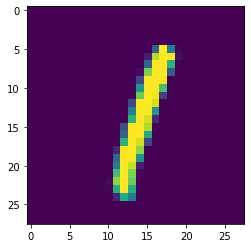

After Autoencoding with 25 neurons


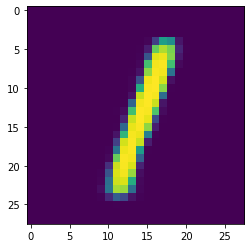

In [19]:
n=5

print('Original Image')
plt.imshow(X_test[n])
plt.show()
print('After Autoencoding with 25 neurons')
plt.imshow(passed_images[n])

# Denoising Images

In [20]:
from tensorflow.keras.layers import GaussianNoise

In [21]:
# takes in a std dev and larger value adds more noise

sample = GaussianNoise(0.2)

In [22]:
noisey = sample(X_test[:10], training = True)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Original Image


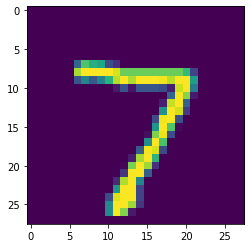

After Noise


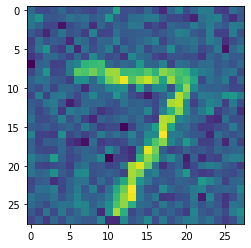

In [24]:
n = 0
print('Original Image')
plt.imshow(X_test[n])
plt.show()
print('After Noise')
plt.imshow(noisey[n])
plt.show()

In [25]:
import tensorflow as tf

In [26]:
# add noise layer to original encoder

tf.random.set_seed(101)

encoder = Sequential()
encoder.add(Flatten(input_shape=[28,28]))

# add the noise generator
encoder.add(GaussianNoise(0.2))

encoder.add(Dense(400, activation='relu'))
encoder.add(Dense(200, activation='relu'))
encoder.add(Dense(100, activation='relu'))
encoder.add(Dense(50, activation='relu'))
encoder.add(Dense(25, activation='relu'))

In [27]:
decoder = Sequential()

decoder = Sequential()
decoder.add(Dense(50, input_shape = [25], activation='relu'))
decoder.add(Dense(100, activation='relu'))
decoder.add(Dense(200, activation='relu'))
decoder.add(Dense(400, activation='relu'))
# checking does input image match output image - binary issue
decoder.add(Dense(784, activation='sigmoid'))
decoder.add(Reshape([28,28]))

In [28]:
noise_remover = Sequential([encoder, decoder])

In [29]:
noise_remover.compile(loss='binary_crossentropy',
                     optimizer = 'adam',
                     metrics = ['accuracy'])

In [30]:
noise_remover.fit(X_train, X_train, epochs = 8)

Train on 60000 samples
Epoch 1/8
60000/60000 [==============================] - 15s 247us/sample - loss: 0.1681 - accuracy: 0.8011
Epoch 2/8
60000/60000 [==============================] - 14s 229us/sample - loss: 0.1302 - accuracy: 0.8078
Epoch 3/8
60000/60000 [==============================] - 14s 229us/sample - loss: 0.1194 - accuracy: 0.8098
Epoch 4/8
60000/60000 [==============================] - 14s 232us/sample - loss: 0.1144 - accuracy: 0.8106
Epoch 5/8
60000/60000 [==============================] - 14s 241us/sample - loss: 0.1108 - accuracy: 0.8112
Epoch 6/8
60000/60000 [==============================] - 15s 246us/sample - loss: 0.1084 - accuracy: 0.8116
Epoch 7/8
60000/60000 [==============================] - 15s 254us/sample - loss: 0.1062 - accuracy: 0.8119
Epoch 8/8
60000/60000 [==============================] - 15s 253us/sample - loss: 0.1046 - accuracy: 0.8121


In [33]:
ten_noisey_images = sample(X_test[:10], training=True)

In [34]:
denoised = noise_remover(ten_noisey_images)

Original Image


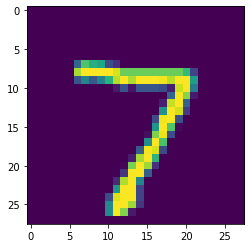

Noise Added Image


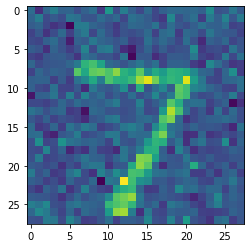

Denoised from Autoencoder


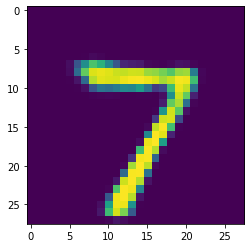

In [35]:
# since auto encoder adds noise to noisey images, double noise

n=0

print('Original Image')
plt.imshow(X_test[n])
plt.show()

print('Noise Added Image')
plt.imshow(ten_noisey_images[n])
plt.show()

print('Denoised from Autoencoder')
plt.imshow(denoised[n])
plt.show()